In [1]:
## Import dependencies.
import os
import itertools
from scipy.io import loadmat, savemat, matlab
import scipy.stats as stt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mou_model import MOU

## Check whether simple_colors is installed, otherwise install using pip
try:
    import simple_colors # for printing colored and bold text
except:
    ! pip install simple_colors

## Import simple_colors
from simple_colors import *

%matplotlib inline
    
## Introduce flags
save_ts_flag = True
save_centered_ts_and_FC_flag = True
save_scaled_FC_flag = True
save_EC_and_model_parametes_flag = True
plot_FC_scaled_avg_flag = True # If == False, FC_avg_scaled is plottet
investigate_BOLD_distribution_flag = True
investigate_FC_distribution_flag = True
investigate_FC_scaled_distribution_flag = True
# Flag 1
quick_optimize_flag = False
if quick_optimize_flag:
    epsilon_C = 0.001
else:
    epsilon_C = 0.0001
FC_scale = 'standard_scale' # Options: 'max_scale', 'standard_scale'
# Flag 2
io_based_on_nodal_degree_flag = False
# Flag 3
allow_all_connections_for_EC_flag = False
# Flag 4
optimize_with_FC_version = 'FC_scaled' # Options: 'FC_scaled','FC'
# Flag 5
input_is_rowsum_flag = True # If == False, input = columnsum

## Introduce constants.
_RES_DIR = str(
    'flag1-' + str(quick_optimize_flag) +
    ' flag2-' + str(io_based_on_nodal_degree_flag) +
    ' flag3-' + str(allow_all_connections_for_EC_flag) +
    ' flag4-' + str(optimize_with_FC_version) +
    ' flag5-' + str(input_is_rowsum_flag) + '/')
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0
seed = 0 # None

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    os.makedirs(_RES_DIR)
    print('created directory:', _RES_DIR)

In [2]:
## The following function was retrieved from 
# https://stackoverflow.com/questions/48970785/complex-matlab-struct-mat-file-read-by-python
# unchanged except from the prints, which were added to give the user a rough 
# idea of the data's structure.
def load_mat(filename):
    """
    This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects.
    """

    def _check_vars(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
#                print(key)
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
#                print(key)
                d[key] = _toarray(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function constructing nested dictionaries from matobjects
        """
#        print('\tcontaining another dictionary with the keys')
        d = {}
        for strg in matobj._fieldnames:
#            print('\t', strg)
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d

    def _toarray(ndarray):
        """
        A recursive function which constructs ndarray from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
#        print('\t\tcontaining an array\n\t\t\tof shape', ndarray.shape, 
#              '\n\t\t\tand dtype', ndarray.dtype)
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray
        
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
 #   print('The data in', filename, 'consists of', len(data.keys()) - 3,
 #         'element(s) with the following keys:\n')
    return _check_vars(data)

In [3]:
## Read in data and structure it.
# Read in SZ data.
fMRI_data = load_mat(
    'schizophrenics_data_and_data_description/cobre_schizo_aparc_ts')
keys_1st_layer = list(fMRI_data.keys())
data_per_subj = fMRI_data[keys_1st_layer[3]]
keys_2nd_layer = list(data_per_subj[0].keys())
#print('Subject with complete data, have the following keys:', str(keys_2nd_layer))
n_subjects = len(data_per_subj)
n_ts_samples, n_rois = data_per_subj[0]['timeseries'].shape 

## Chose only subjects for whom the full timeseries is present
timeseries = np.zeros([n_subjects, n_ts_samples, n_rois])
for i, i_subj in enumerate(data_per_subj):
    #print(i, '\t\t:', i_subj.keys())
    timeseries[i, :, :] = i_subj.get('timeseries')

## Exclude subjects who are marked for exclusion
subj_infos = pd.read_excel(
    'schizophrenics_data_and_data_description/cobre_schizoprenia.xlsx', header = 1)
mask_exclude_subj = subj_infos.loc[: , "Exlude?"]
mask_exclude_subj = mask_exclude_subj.replace("Motion",1)
mask_exclude_subj = mask_exclude_subj.replace("Disenrolled",1)
mask_exclude_subj = mask_exclude_subj.replace("Incomplete",1)
mask_exclude_subj = mask_exclude_subj.replace(np.nan,0)
mask_exclude_subj = mask_exclude_subj.to_numpy(dtype=bool)
ts_mixed = timeseries[~mask_exclude_subj]

## Separate healthy participants from schizophrenics
participant_type_labels = ["Control", "Patient"]
mask_patient_subj = subj_infos.loc[: , "Subject Type"]
mask_patient_subj = mask_patient_subj.replace(participant_type_labels[0],0)
mask_patient_subj = mask_patient_subj.replace(participant_type_labels[1],1)
mask_patient_subj = mask_patient_subj.to_numpy(dtype=bool)
mask_patient_subj = mask_patient_subj[~mask_exclude_subj]
ts_patients = ts_mixed[mask_patient_subj]
ts_patients = ts_patients[
    np.logical_not(np.isnan(ts_patients))].reshape((-1,150,68))
ts_controls = ts_mixed[~mask_patient_subj]
ts_controls = ts_controls[
    np.logical_not(np.isnan(ts_controls))].reshape((-1,150,68))
ts_patients = np.transpose(ts_patients, (0, 2, 1))
ts_controls = np.transpose(ts_controls, (0, 2, 1))
n_patients, n_rois_patients, n_ts_samples_patients = ts_patients.shape
n_controls, n_rois_controls, n_ts_samples_controls = ts_controls.shape
print('Participants with complete data:')
print('\t', n_patients, 'patient participants')
print('\t', n_controls, 'control participants')

# Read in ROI labels.
roi_labels_pd = pd.read_excel(
    'schizophrenics_data_and_data_description/cobre_schizoprenia.xlsx', 
    sheet_name='regions', usecols='C', header=1)
roi_labels_pd = roi_labels_pd.replace({'ctx-':''}, regex=True)
roi_labels_pd = roi_labels_pd.replace({' ':''}, regex=True)
roi_labels_pd = roi_labels_pd.replace({'-':'_'}, regex=True)
roi_labels = np.concatenate(roi_labels_pd.to_numpy())

Participants with complete data:
	 60 patient participants
	 69 control participants


Investigate distribution of BOLD timeseries values:


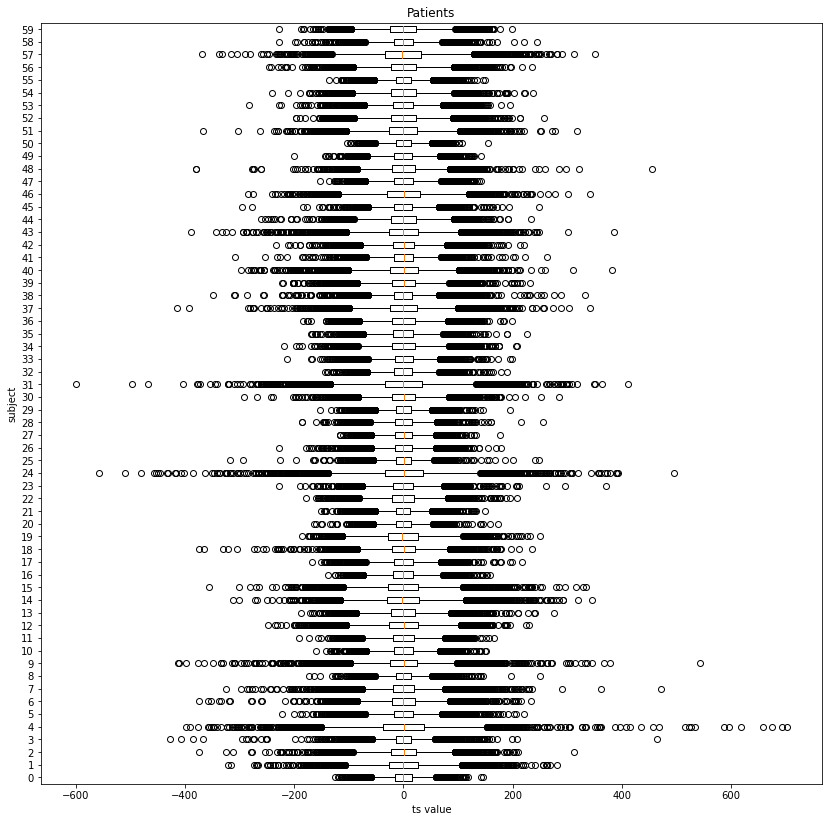

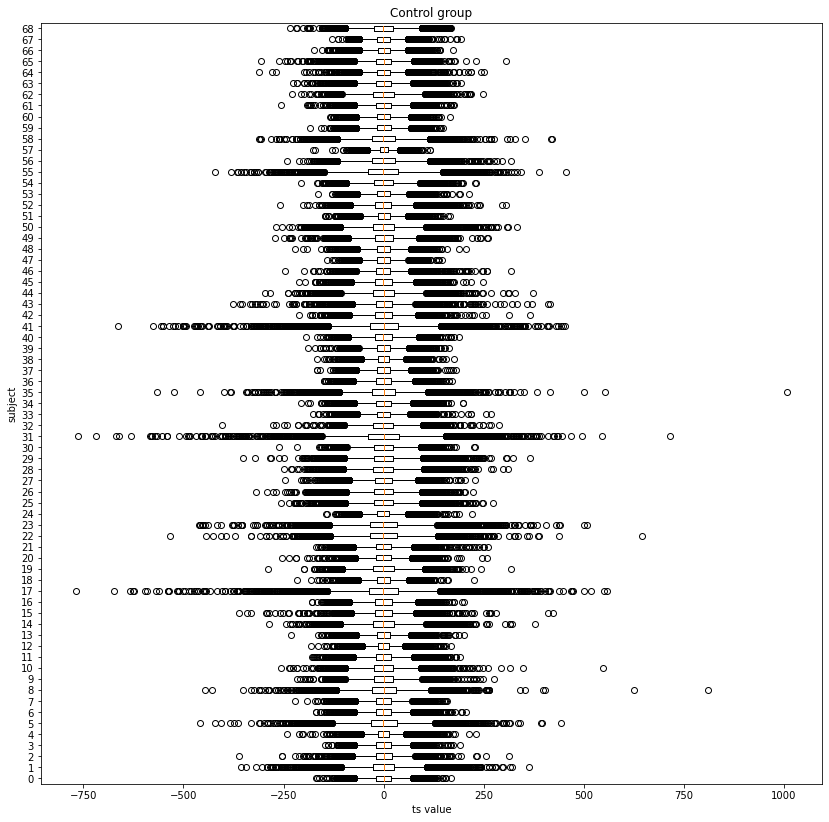

In [4]:
## Investigate distribution of FC values
def plot_ts_boxplot(BOLD_ts, group):
    plt.figure(figsize=(14, 14))
    plt.title(group)
    plt.ylabel('subject')
    plt.xlabel('ts value')
    n_subjects = BOLD_ts.shape[0]
    BOLD_ts = np.reshape(BOLD_ts, [n_subjects, -1])
    plt.boxplot(BOLD_ts.T, positions = np.arange(n_subjects), vert=False)
    plt.show()

if investigate_BOLD_distribution_flag:
    print(red('Investigate distribution of BOLD timeseries values:', 'bold'))
    plot_ts_boxplot(ts_patients, 'Patients')
    plot_ts_boxplot(ts_controls, 'Control group')

In [5]:
if save_ts_flag:
    # Save faultless timeseries sorted into patient & control group.
    np.save(_RES_DIR + 'ts_patients.npy', ts_patients)
    np.save(_RES_DIR + 'ts_controls.npy', ts_controls)
else:
    # Load faultless timeseries sorted into patients and control.
    ts_patients = np.load(_RES_DIR + 'ts_patients.npy')
    ts_controls = np.load(_RES_DIR + 'ts_controls.npy')

In [6]:
### Length of BOLD data dependent on tau like in tau_lag_correlation.m.
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
def calculate_FC_shift(filtered_ts_emp, n_shifts, **kwargs):
    n_subjects, n_rois, n_ts_samples = filtered_ts_emp.shape
    centered_ts = np.copy(filtered_ts_emp)
    FC_shift = np.zeros([n_subjects, n_rois, n_rois])
    FC_Reuters = np.zeros([n_subjects, n_rois, n_rois])
    n_ts_span = n_ts_samples - n_shifts
    for i_subject in range(n_subjects):
        # Center the time series (around zero).
        centered_ts[i_subject, :, :] -=  \
                np.outer(centered_ts[i_subject, :, :].
                         mean(axis=1), np.ones([n_ts_samples]))
        # Calculate covariances with one time shift.
        for i_roi in range(n_rois):
            FC_shift[i_subject, :, i_roi] = \
            np.dot(centered_ts[i_subject, :, :n_ts_span], 
                   centered_ts[i_subject, i_roi,
                               n_shifts:]) / float(n_ts_span)               
    return centered_ts, FC_shift

In [7]:
## Calculate functional connectivity FC (BOLD covariances).
time_shifts = np.arange(4, dtype=int)
n_shifts = len(time_shifts)
if save_centered_ts_and_FC_flag:
    ## Patient FC.
    FC_patients = np.ndarray([n_patients, n_shifts, 
                              n_rois_patients, n_rois_patients])
    for time_shift in time_shifts:
        centered_ts_patients, FC_patients[:, time_shift, :, :] = \
        calculate_FC_shift(ts_patients, time_shift)

    ## Control FC.
    FC_controls = np.ndarray([n_controls, n_shifts, 
                              n_rois_controls, n_rois_controls])
    for time_shift in time_shifts:
        centered_ts_controls, FC_controls[:, time_shift, :, :] = \
        calculate_FC_shift(ts_controls, time_shift)

In [8]:
if save_centered_ts_and_FC_flag:
    # Save faultless centered timeseries sorted into patient & control group.
    np.save(_RES_DIR + 'centered_ts_patients.npy', centered_ts_patients)
    np.save(_RES_DIR + 'centered_ts_controls.npy', centered_ts_controls)
    # Save raw FC.
    np.save(_RES_DIR + 'FC_patients.npy', FC_patients)
    np.save(_RES_DIR + 'FC_controls.npy', FC_controls)
else:
    # Load faultless centered timeseries sorted into patients and control.
    centered_ts_patients = np.load(_RES_DIR + 'centered_ts_patients.npy')
    centered_ts_controls = np.load(_RES_DIR + 'centered_ts_controls.npy')
    # Load raw FC.
    FC_patients = np.load(_RES_DIR + 'FC_patients.npy')
    FC_controls = np.load(_RES_DIR + 'FC_controls.npy')

In [9]:
## Test cell to show that the standardscaling does what it is supposed to do.
import statistics
## Use tested implementation from min_max_scaler
standard_scaler = StandardScaler()
FC0 = FC_patients[:, _I_NO_TIMESHIFT, :, :]
FC0_scaled = np.zeros([n_patients, n_rois, n_rois])
std = np.zeros([n_patients])

for i_subj in range(n_patients):
    FC0_scaled[i_subj, :, :] = standard_scaler.fit_transform(
        FC0[i_subj,:,:].reshape(-1, 1)).reshape(n_rois, n_rois)
    ## Standard scale per subject manually
    std[i_subj] = statistics.pstdev(FC0[i_subj,:,:].reshape(-1))
FC0_scaled_test2 = (FC0-FC0.mean(axis=1).mean(axis=1)[:, np.newaxis, np.newaxis])/std[:, np.newaxis,np.newaxis]
## Compare both versions (manually and with tested implementation)
#print(np.isclose(FC0_scaled, FC0_scaled_test2).all())

#print(standard_scaler.mean_, standard_scaler.scale_)
#import statistics
#print([FC0.mean(), statistics.pstdev(FC0.reshape(-1))])

## Compare result of final implementation with manually calculated results. 
standard_scaler = StandardScaler()
FC0_scaled_test = standard_scaler.fit_transform(
    FC0[:,:,:].reshape(n_patients, -1).T).T.reshape(FC0.shape)
FC_scaler = lambda matrix_3d: standard_scaler.transform(
    matrix_3d.reshape(n_patients, -1).T).T.reshape(matrix_3d.shape)
FC_emp = FC_scaler(FC_patients)
#print(standard_scaler.mean_.shape, standard_scaler.mean_)
#print(standard_scaler.scale_.shape, standard_scaler.scale_)

#print(np.isclose(FC0_scaled, FC0_scaled_test).all())
#print(np.isclose(FC_emp[:,0,:,:], FC0_scaled).all())
#print(np.isclose(FC_emp.mean(axis=2).mean(axis=2)[:,0], np.zeros([60,1])).all())

## Analyse distribution of FC values per subject to determine best 
# normalization or scaling option.
alpha = 0.05
#save_centered_ts_and_FC_flag = True
if save_centered_ts_and_FC_flag:
    conf_int_rc = np.array(stt.t.interval(
        1-alpha, FC0.shape[0]-1,
        loc=FC_patients.mean(axis=2).mean(axis=2),
        scale=stt.sem(FC_patients.reshape(n_patients, n_shifts, -1), axis=2))).T
FC_scaled = FC_patients/FC_patients.mean(axis=2).mean(axis=2)[:, :, np.newaxis, np.newaxis]
#stt.sem(FC_scaled.reshape(n_patients, n_shifts, -1), axis=2)

In [10]:
def standard_scale(FC):
    """Standardize FC so that mean=0 and std=1 for FC0
    
    This function scales the FC according to z = (x - u) / s, where x is the
    unscaled FC, u it's mean and s the standard diviation. The scaler scales
    all the FC (for all time shifts) with the mean and standard diviation of
    FC0.
    """
    n_subjects = FC.shape[0]
    standard_scaler = StandardScaler()
    standard_scaler.fit(FC[:,_I_NO_TIMESHIFT,:,:].reshape(n_subjects, -1).T)
    FC_scaler = lambda matrix_3d: standard_scaler.transform(
        matrix_3d.reshape(n_subjects, -1).T).T.reshape(matrix_3d.shape)
    # The following commented version is equivalent to the uncommented version
    # below. Only here the scaler is applied, while it is not in the version 
    # below.
#    FC_scaled = (FC_scaler(FC)
#                 + standard_scaler.mean_[
#                     :, np.newaxis, np.newaxis, np.newaxis]
#                 / standard_scaler.scale_[
#                     :, np.newaxis, np.newaxis, np.newaxis])

    FC_scaled = FC / standard_scaler.scale_[
        :, np.newaxis, np.newaxis, np.newaxis]
    
    #FC_scaled = FC_scaler(FC) # results in Infs or NANs error in solve_lyapunov()
    FC_scaled = FC_scaled / FC_scaled.max()
    #max(axis=1).max(axis=1)[:, np.newaxis, np.newaxis]
    #print(np.isclose(FC_scaled, FC_emp).all())
    return FC_scaled

In [11]:
def max_scale(FC):
    """Scale FC so that the max value of every subject's FC is 1.
    
    This function devides every subject's FC by it's maximal value.  
    """
    FC_scaled = FC/FC[:, _I_NO_TIMESHIFT,:, :].max(
        axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
    return FC_scaled

Due to the application of the min-max-scaler most of the FC values should be between 0 and 1
Min FC0 value: -0.17545314764169956
Mean FC0 value: 0.019229533890892075
Max FC0 value: 1.0
Mean BOLD variance (diagonal of each FC0 matrix): 0.3676555215582122


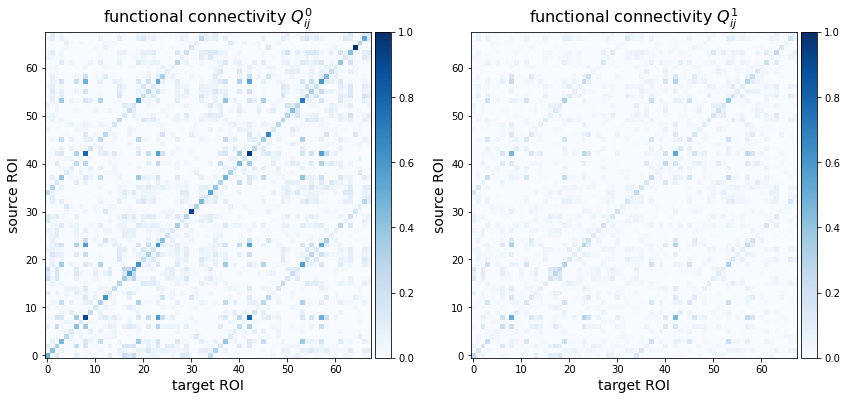

Due to the application of the min-max-scaler most of the FC values should be between 0 and 1
Min FC0 value: -0.12617988277807213
Mean FC0 value: 0.02092174762117995
Max FC0 value: 1.0
Mean BOLD variance (diagonal of each FC0 matrix): 0.2954003778835218


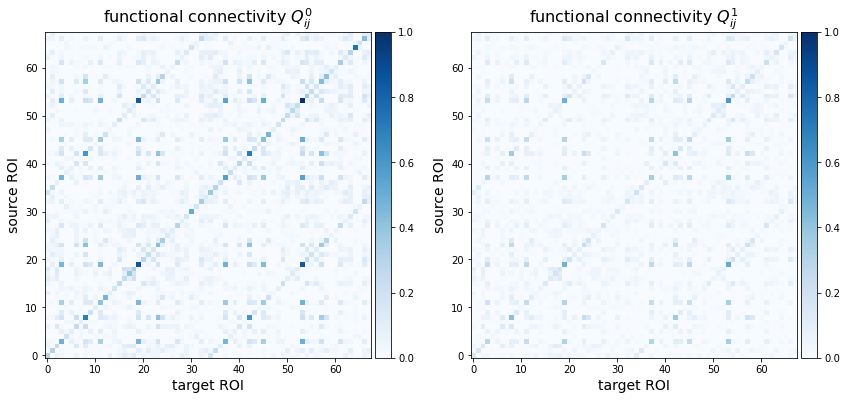

In [12]:
## Scale/normalize FC per subject by dividing by maximum FC value.
#save_centered_ts_and_FC_flag = True
if save_centered_ts_and_FC_flag:
    # Scale FC so that the max value of every subject's FC is 1.
    if FC_scale == 'max_scale':
        FC_scaled_patients = max_scale(FC_patients)
        # Visualize the effect of the scaling by printing the relevant values.
        #print('Maxima of FC_scaled_patients:\n\n',
        #      FC_scaled_patients.max(axis=2).max(axis=2
        FC_scaled_controls = max_scale(FC_controls)
        # Visualize the effect of the scaling by printing the relevant values.
        #print('Maxima of FC_scaled_controls:\n\n',
        #      FC_scaled_controls.max(axis=2).max(axis=2))
    elif FC_scale == 'standard_scale':
        FC_scaled_patients = standard_scale(FC_patients)
        FC_scaled_controls = standard_scale(FC_controls)
    
    ## Patients group.
    # Average FC over subjects.
    FC_avg_patients = FC_patients.mean(axis=_SUBJECT_AXIS)
    FC_scaled_avg_patients = FC_scaled_patients.mean(axis=_SUBJECT_AXIS)
    # Scale FC_avg so that the maximal value for each run is 1.
    FC_avg_scaled_patients = FC_avg_patients/FC_avg_patients[
        _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
        np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('\nMaxima of FC_avg_scaled_patients:\n\n',
    #      FC_avg_scaled_patients.max(axis=2).max(axis=2))

    if plot_FC_scaled_avg_flag:
        plotted_FC_version = FC_scaled_avg_patients
    else:
        plotted_FC_version = FC_avg_scaled_patients
        
    rescale_factor_for_plot = 1 / plotted_FC_version.max()
    plotted_FC_version *= rescale_factor_for_plot
    print('Due to the application of the min-max-scaler most of the FC values'
    ' should be between 0 and 1')
    print('Min FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].min())
    print('Mean FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].mean())
    print('Max FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].max())
    print('Mean BOLD variance (diagonal of each FC0 matrix):', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].diagonal(
              axis1=0, axis2=1).mean())
    # # Show distibution of FC0 values.
    # plt.figure()
    # plt.hist(plotted_FC_version[_I_NO_TIMESHIFT, :, :].flatten(),
    #          bins=np.linspace(-1, 5, 30))
    # plt.xlabel('FC0 value', fontsize=14)
    # plt.ylabel('matrix element count', fontsize=14)
    # plt.title('distribution of FC0 values')

    # Show FC0 averaged over subjects.
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    FC0 = plotted_FC_version[_I_NO_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC0, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

    # Show FC1 averaged over subjects for.
    plt.subplot(122)
    FC1 = plotted_FC_version[_I_ONE_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC1, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
    plt.show()

    ## Control group.
    # Average FC over subjects.
    FC_avg_controls = FC_controls.mean(axis=_SUBJECT_AXIS)
    FC_scaled_avg_controls = FC_scaled_controls.mean(axis=_SUBJECT_AXIS)
    # Scale FC_avg so that the maximal value for each run is 1.
    FC_avg_scaled_controls = FC_avg_controls/FC_avg_controls[
        _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
        np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('\nMaxima of FC_avg_scaled_controls:\n\n',
    #      FC_avg_scaled_controls.max(axis=2).max(axis=2))

    if plot_FC_scaled_avg_flag:
        plotted_FC_version = FC_scaled_avg_controls
    else:
        plotted_FC_version = FC_avg_scaled_controls

    rescale_factor_for_plot = 1 / plotted_FC_version.max()
    plotted_FC_version *= rescale_factor_for_plot
    print('Due to the application of the min-max-scaler most of the FC values'
    ' should be between 0 and 1')
    print('Min FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].min())
    print('Mean FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].mean())
    print('Max FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].max())
    print('Mean BOLD variance (diagonal of each FC0 matrix):', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].diagonal(
              axis1=0, axis2=1).mean())
    #     # Show distibution of FC0 values.
    #     plt.figure()
    #     plt.hist(plotted_FC_version[_I_NO_TIMESHIFT, :, :].flatten(),
    #              bins=np.linspace(-1, 5, 30))
    #     plt.xlabel('FC0 value', fontsize=14)
    #     plt.ylabel('matrix element count', fontsize=14)
    #     plt.title('distribution of FC0 values')

    # Show FC0 averaged over subjects.
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    FC0 = plotted_FC_version[_I_NO_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC0, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

    # Show FC1 averaged over subjects for.
    plt.subplot(122)
    FC1 = plotted_FC_version[_I_ONE_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC1, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
    plt.show()

In [13]:
if save_scaled_FC_flag:
    # Save scaled FC.
    np.save(_RES_DIR + 'FC_scaled_patients.npy', FC_scaled_patients)
    np.save(_RES_DIR + 'FC_scaled_controls.npy', FC_scaled_controls)
else:
    # Load scaled FC.
    FC_scaled_patients = np.load(_RES_DIR + 'FC_scaled_patients.npy')
    FC_scaled_controls = np.load(_RES_DIR + 'FC_scaled_controls.npy')

Investigate distribution of FC values:


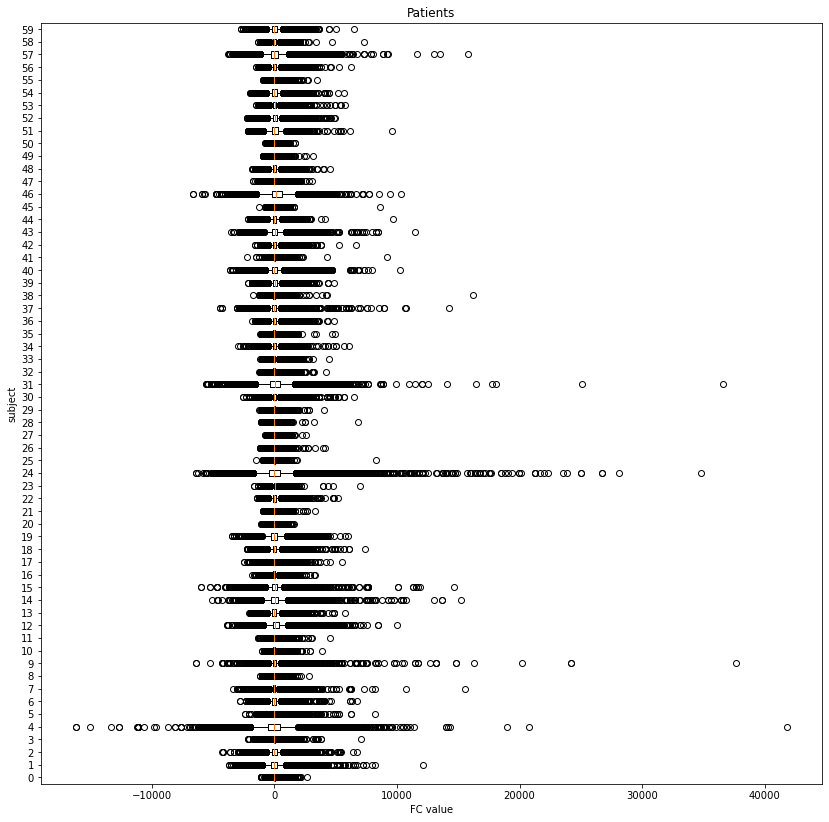

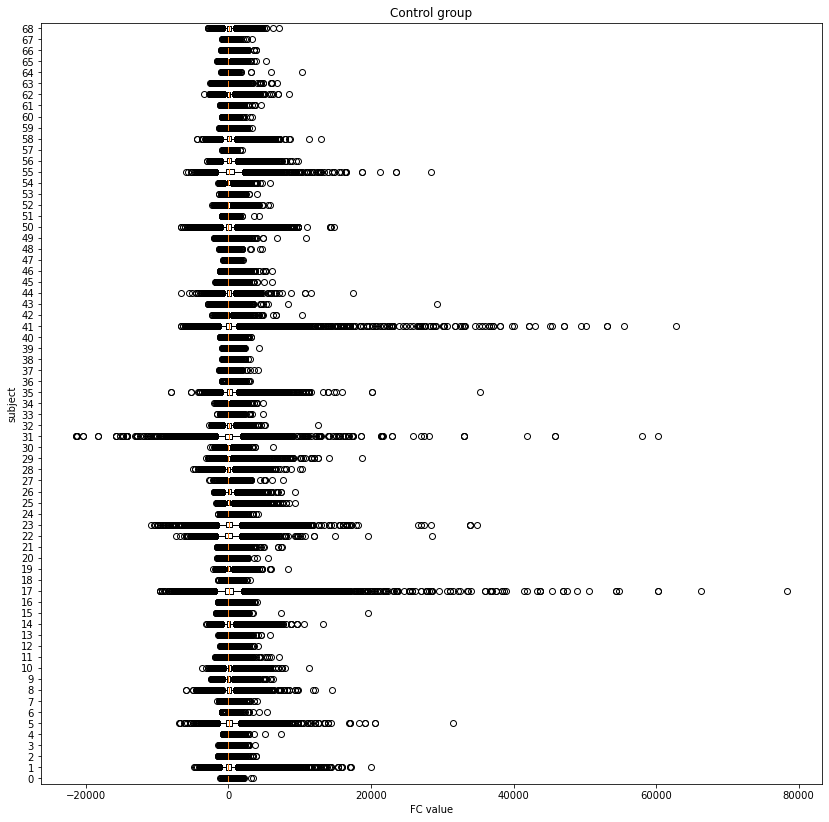

Investigate distribution of scaled FC values:


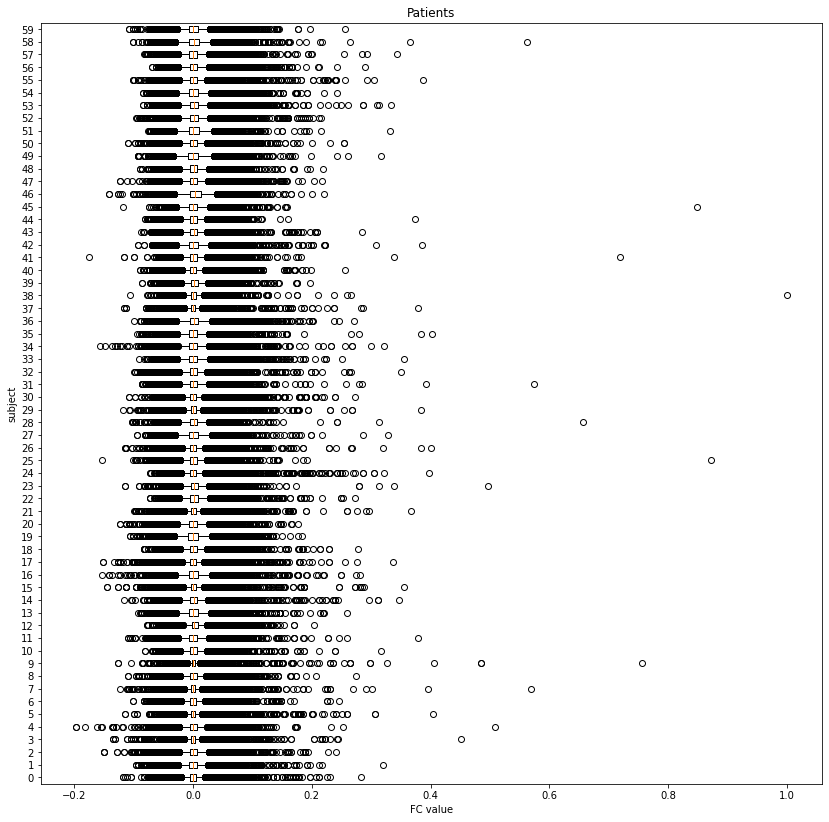

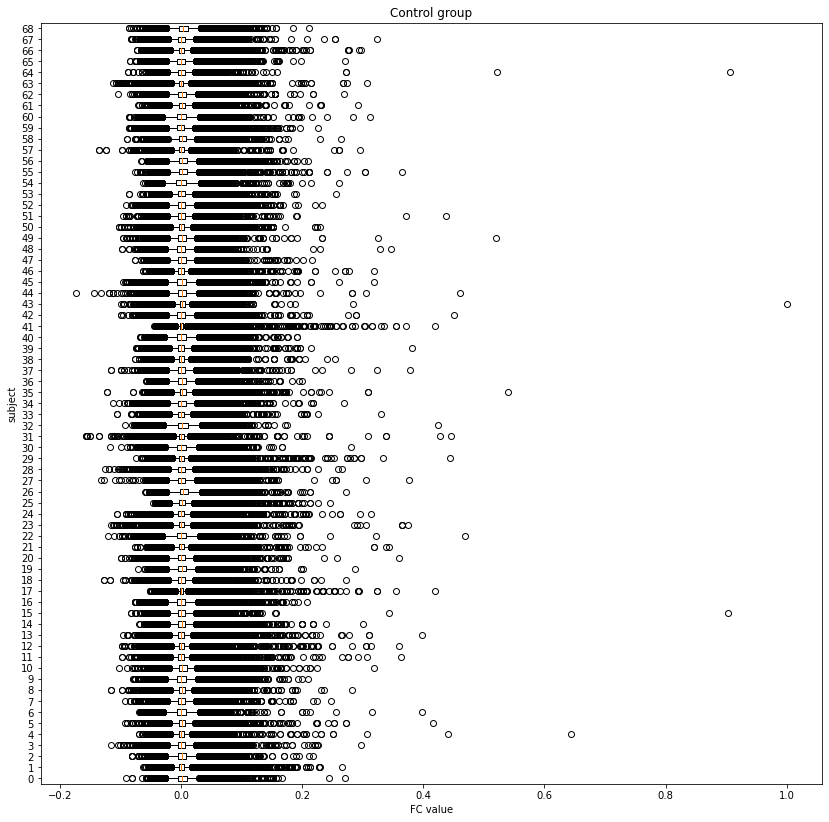

In [14]:
## Investigate distribution of FC values
def plot_FC_boxplot(FC, group):
    plt.figure(figsize=(14, 14))
    plt.title(group)
    plt.ylabel('subject')
    plt.xlabel('FC value')
    n_subjects = FC.shape[0]
    FC = np.reshape(FC, [n_subjects, -1])
    plt.boxplot(FC.T, positions = np.arange(n_subjects), vert=False)
    plt.show()

if investigate_FC_distribution_flag:
    print(red('Investigate distribution of FC values:', 'bold'))
    plot_FC_boxplot(FC_patients, 'Patients')
    plot_FC_boxplot(FC_controls, 'Control group')
if investigate_FC_scaled_distribution_flag:
    print(red('Investigate distribution of scaled FC values:', 'bold'))
    plot_FC_boxplot(FC_scaled_patients, 'Patients')
    plot_FC_boxplot(FC_scaled_controls, 'Control group')

In [15]:
print(FC_patients[4,0,30,30])
print(FC_scaled_patients[4,0,30,30])
print(np.where(FC_scaled_patients==FC_scaled_patients[:,0,:,:].max()))
print(np.where(FC_patients==FC_patients[:,0,:,:].max()))
print(FC_patients[:,0,:,:].max())
print('Maximum of FC_patients:', FC_scaled_patients[:,:,:,:].max())
print('Maximum of FC_controls:', FC_scaled_controls[:,:,:,:].max())
print(FC_patients[:,1,:,:].max())
print(standard_scaler.scale_)
print(standard_scaler.mean_)

41778.03760119404
0.5094193530703955
(array([38], dtype=int64), array([0], dtype=int64), array([64], dtype=int64), array([64], dtype=int64))
(array([4], dtype=int64), array([0], dtype=int64), array([30], dtype=int64), array([30], dtype=int64))
41778.03760119404
Maximum of FC_patients: 1.0
Maximum of FC_controls: 1.0
28090.036308784904
[ 238.24238102  960.69024059  715.51216214  395.56088865 2080.91422952
  517.68898696  695.33534121  691.09940615  264.489482   1265.25093143
  310.52395281  305.78313152 1251.72160275  562.86178021 1112.59660059
 1046.32824624  297.74527012  418.13250773  675.39871475  827.74610047
  228.20232283  229.88919903  486.3212385   358.18679575 2220.71518011
  242.29805128  262.01798262  200.07047287  264.03506877  268.59143612
  604.88920111 1619.17352198  306.33112821  321.47964551  479.88294955
  310.44811302  454.56237564  955.13783299  411.8011495   634.74755086
 1018.54035451  325.45580539  438.17244813 1024.84457128  657.51274342
  258.20553152 1189.8748

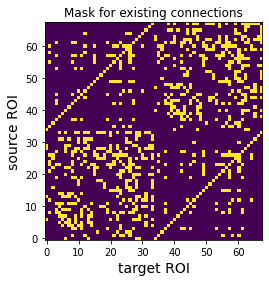

In [16]:
## Include structural connectivity.
# Load the binary structural connectivity matrix.
mask_EC = np.array(loadmat('BOLD_data_and_SC_matrix/BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce hermispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True
plotted_mask_EC = mask_EC

if allow_all_connections_for_EC_flag:
    mask_EC = None
    plotted_mask_EC = np.ones([n_rois, n_rois])
    
# Visualise the binary structural connectivity mask.
plt.figure()
plt.imshow(plotted_mask_EC, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)
plt.show()

In [17]:
def calculate_EC(FC, mask_EC, **kwargs):
    """Calculate the EC per subject based on the BOLD timeseries.
    
    The matrixes FC0 and FC1 (covariances of BOLD signal without and with one
    time shift) are passed directly to fit_LO()@MOU for reasons explained in 
    the cell following this cell. In fit_LO()@MOU the EC (C matrix) and the 
    local variability (Sigma matrix) are calculated.
    """
    # Construct diagonal mask for input noise matrix
    # (here, no input cross-correlation).
    n_subjects, _, n_rois, _ = FC.shape

    # Run the model optimization.
    # Initialize the source arrays.
    # Jacobian (off-diagonal elements = EC)
    J_mod = np.zeros([n_subjects, n_rois, n_rois])
    # Local variance (input covariance matrix, chosen to be diagonal)
    Sigma_mod = np.zeros([n_subjects, n_rois, n_rois])
    # Model error
    dist_mod = np.zeros([n_subjects])
    # Approximation of variance about the fitted data (FC covariance matrices)
    R2_mod = np.zeros([n_subjects])
    # Between-region EC matrix
    C_mod = np.zeros([n_subjects, n_rois, n_rois])
    
    i_tau_opt = 1
    C = np.zeros([n_rois_patients, n_rois_patients])
    mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().
    mask_Sigma = np.eye(n_rois, dtype=bool)

    print('NANs: ', np.isnan(FC).any(), '\tInfs: ', np.isinf(FC).any())
    for i_subject in range(n_subjects):
        print('Max: ', FC[i_subject, :, :, :].max(), 'Min: ', FC[i_subject, :, :, :].min())
        # Run the estimation of model parameters, for all sessions.
        mou_model.fit_LO(FC[i_subject, :, :, :], i_tau_opt,
                         mask_Sigma=mask_Sigma, mask_C=mask_EC, **kwargs)
        # Organize the optimization results into arrays.
        # Extract Jacobian of the model.
        J_mod[i_subject, :, :] = mou_model.J
        # Extract noise (auto-)covariance matrix.
        Sigma_mod[i_subject, :, :] = mou_model.Sigma
        # Extract the matrix distance between the empirical objective
        # covariances and their model counterparts
        # (normalized for each objective matrix).
        dist_mod[i_subject] = mou_model.d_fit['distance']
        # The squared Pearson correlation is taken as an approximation
        # of the variance.
        R2_mod[i_subject] = mou_model.d_fit['correlation']**2
        # The between-region EC matrix of the model
        C_mod[i_subject, :, :] = mou_model.get_C()
        C_mod_dict = dict(C_mod = C_mod,
                          epsilon_C = epsilon_C)

        print('sub:', i_subject, ';\t model error, R2:',
              dist_mod[i_subject], R2_mod[i_subject])
    return [J_mod, Sigma_mod, dist_mod, R2_mod, C_mod_dict]

# Comments on function calculate_EC()

It is possible to directly pass the timeseries of the individual
subjects to fit()@MOU. In that case, however, the matrixes FC0 and FC1
(covariances of BOLD signal without and with one time shift)are calculated
in that function. They are not scaled in the original version by 
Andrea Insabato, Gorka Zamora-López and Matthieu Gilson and the method
solve_continuous_lyapunov() throws an error ('array must not contain infs
or NaNs'). As I want to keep the original version as unaltered as 
possible, the FC matrixes are calculated and scaled beforehand and passed
directly to the method fit_LO()@MOU.

Note that the calculation of the FC in fit()@MOU differs a bit from the 
calculation above (calculate_FC_shift). The length of the timeseries, 
for which the covariances are calculated all have the same length in 
fit()@MOU - as long as the maximum time shift allows. In the above 
version, on the other hand, the timeseries are chosen as long as possible
for each time shift individually.

In [20]:
## Calculate EC for each subject's EC.
save_EC_and_model_parametes_flag = True
if save_EC_and_model_parametes_flag:
    print(black('Calculate EC for patients:\n', 'bold'))
    [J_patients, Sigma_patients, dist_patients, R2_patients, 
     C_patients_dict] = calculate_EC(FC_scaled_patients, mask_EC, epsilon_C=epsilon_C)
    print('Finished!\n')
    print(black('Calculate EC for control group:\n', 'bold'))
    [J_controls, Sigma_controls, dist_controls, R2_controls, 
     C_controls_dict] = calculate_EC(FC_scaled_controls, mask_EC, epsilon_C=epsilon_C)
    print('Finished!\n')

Calculate EC for patients:

NANs:  False 	Infs:  False
Max:  0.28248509225592133 Min:  -0.11841633992265879
sub: 0 ;	 model error, R2: 0.8298703405263688 0.3992026223822126
Max:  0.3192968480583922 Min:  -0.09647377628330384
sub: 1 ;	 model error, R2: 0.8167297273726708 0.4067778229528731
Max:  0.24067603835021648 Min:  -0.15030309650172452
sub: 2 ;	 model error, R2: 0.8740714186916795 0.2934301085245697
Max:  0.451724260157171 Min:  -0.13574950577115807
sub: 3 ;	 model error, R2: 0.8936259904764392 0.35068085832151263
Max:  0.5094193530703955 Min:  -0.196657123067015
sub: 4 ;	 model error, R2: 0.8504899246129324 0.3243088159235863
Max:  0.40381664770624043 Min:  -0.11495004776463572
sub: 5 ;	 model error, R2: 0.9292420910289759 0.3714518136513126
Max:  0.2458679746682686 Min:  -0.10163723252075652
sub: 6 ;	 model error, R2: 0.8989661896436696 0.30151289168825907
Max:  0.569522910398426 Min:  -0.12357390652677631
sub: 7 ;	 model error, R2: 0.9023578457921133 0.24492379732793831
Max:  0

sub: 8 ;	 model error, R2: 0.7772768517631958 0.40220194279773797
Max:  0.20870145305319449 Min:  -0.07883992117997125
sub: 9 ;	 model error, R2: 0.8426671038587779 0.3763051388647057
Max:  0.3177698278620139 Min:  -0.10317650342439942
sub: 10 ;	 model error, R2: 0.6630243579969406 0.6239927686283012
Max:  0.3633102063459899 Min:  -0.0972014494263794
sub: 11 ;	 model error, R2: 0.7700889824094556 0.49304168909793805
Max:  0.3594686563477684 Min:  -0.09821163894075921
sub: 12 ;	 model error, R2: 0.7745313143840883 0.5192529607411711
Max:  0.39755011048128397 Min:  -0.09625004680341465
sub: 13 ;	 model error, R2: 0.7448847554952348 0.6216620733042436
Max:  0.3002413424035367 Min:  -0.06911753460898401
sub: 14 ;	 model error, R2: 0.7482897405840458 0.5645585114557671
Max:  0.9029107285027965 Min:  -0.08245057875686466
sub: 15 ;	 model error, R2: 0.8851549431222504 0.17789246724390273
Max:  0.20740019482501784 Min:  -0.0764905538480837
sub: 16 ;	 model error, R2: 0.8456621729610622 0.35565

In [30]:
if save_EC_and_model_parametes_flag:
    # Save EC per subject for patients & control group.
    np.save(_RES_DIR + 'C_patients_dict.npy', C_patients_dict)
    np.save(_RES_DIR + 'C_controls_dict.npy', C_controls_dict)
    # Save model parametes.
    np.save(_RES_DIR + 'J_patients.npy', J_patients)
    np.save(_RES_DIR + 'J_controls.npy', J_controls)
    np.save(_RES_DIR + 'Sigma_patients.npy', Sigma_patients)
    np.save(_RES_DIR + 'Sigma_controls.npy', Sigma_controls)
    np.save(_RES_DIR + 'dist_patients.npy', dist_patients)
    np.save(_RES_DIR + 'dist_controls.npy', dist_controls)
    np.save(_RES_DIR + 'R2_patients.npy', R2_patients)
    np.save(_RES_DIR + 'R2_controls.npy', R2_controls)
else:
    # Load EC per subject for patients & control group.
    C_patients_dict = np.load(_RES_DIR + 'C_patients.npy', allow_pickle=True).tolist()
    C_controls_dict = np.load(_RES_DIR + 'C_controls.npy', allow_pickle=True).tolist()
    # Load model parametes.
    J_patients = np.load(_RES_DIR + 'J_patients.npy')
    J_controls = np.load(_RES_DIR + 'J_controls.npy')
    Sigma_patients = np.load(_RES_DIR + 'Sigma_patients.npy')
    Sigma_controls = np.load(_RES_DIR + 'Sigma_controls.npy')
    dist_patients = np.load(_RES_DIR + 'dist_patients.npy')
    dist_controls = np.load(_RES_DIR + 'dist_controls.npy')
    R2_patients = np.load(_RES_DIR + 'R2_patients.npy')
    R2_controls = np.load(_RES_DIR + 'R2_controls.npy')
C_patients = C_patients_dict['C_mod']
C_controls = C_controls_dict['C_mod']

In [34]:
## Examine input and output to and from the RC.
def calculate_RC_input_and_output(C, input_is_rowsum=input_is_rowsum_flag):
    if input_is_rowsum:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    # Create a 2D-mask for inter rich club connections.
    mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
    rc_ind_combin = np.array(list(
        itertools.product(indexes_rich_club, repeat=2))).T
    mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True

    no_rc_connections_C = np.copy(C)
    no_rc_connections_C[mask_inter_rc] = 0
    if io_based_on_nodal_degree_flag:
        input_rc = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                                axis=input_axis, keepdims=True))
        output_rc = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                                 axis=output_axis, keepdims=True))
    else:
        input_rc = no_rc_connections_C[:, :].sum(axis=input_axis)
        output_rc = no_rc_connections_C[:, :].sum(axis=output_axis)

#    io_ratio_rc = input_rc[mask_rc] / output_rc[mask_rc]
#    # Calculate and print the mean io-ratio and the CI for rich club regions
#    io_ratio_rc_mean = io_ratio_rc[:].mean()
#    io_ratio_rc_conf_int = np.array(stt.t.interval(
#        0.95, io_ratio_rc.shape[0]-1, loc=io_ratio_rc_mean,
#        scale=stt.sem(io_ratio_rc)))
#    print('Mean input-to-output ratio of the rich club:\n',
#          str(io_ratio_rc_mean))
#    print('95% confidence interval (rich club):\n', str(io_ratio_rc_conf_int))
#    rc_ratio_of_total_io = (roi_input[mask_rc].sum()
#                            / roi_output[mask_rc].sum())
#    print('Total input to total output ratio between RC and periphery:\n',
#          str(rc_ratio_of_total_io))

    # Create a 2D-mask for inter periphery connections.
    mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
    periph_ind_combin = np.array(list(itertools.product(list(
        x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
    mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
    # Calculate the ratio of incoming/outgoing EC among peripheral regions
    inter_periph_C = np.copy(C)
    inter_periph_C[~mask_inter_periph] = 0
    if io_based_on_nodal_degree_flag:
        input_periph = np.squeeze(np.count_nonzero(
            inter_periph_C, axis=input_axis, keepdims=True))
        output_periph = np.squeeze(np.count_nonzero(
            inter_periph_C, axis=output_axis, keepdims=True))
    else:
        input_periph = inter_periph_C[:, :].sum(axis=input_axis)
        output_periph = inter_periph_C[:, :].sum(axis=output_axis)

#    io_ratio_periph = (input_periph[~mask_rc] / output_periph[~mask_rc])
#    # Calculate and print the mean io-ratio and the CI for peripheral regions
#    io_ratio_periph_mean = io_ratio_periph.mean()
#    io_ratio_periph_conf_int = np.array(stt.t.interval(
#        0.95, io_ratio_periph.shape[0]-1, loc=io_ratio_periph_mean,
#        scale=stt.sem(io_ratio_periph)))
#    print('Mean input-to-output ratio of the priphery:\n',
#          str(io_ratio_periph_mean))
#    print('95% confidence interval (periphery):\n',
#          str(io_ratio_periph_conf_int))
#    periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
#                                / roi_output[~mask_rc].sum())
#    print('Total input to total output ratio of the priphery:\n',
#          str(periph_ratio_of_total_io))
    return input_rc, output_rc, input_periph, output_periph

# Define RC
rc_labels = ['precuneus', 'superiorfrontal', 'superiorparietal']
mask_rc = np.zeros(n_rois, dtype=bool)
for i_rc_label in rc_labels:
    mask_rc[np.frompyfunc(lambda x: i_rc_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_rich_club = np.array(*np.where(mask_rc))
print(black('Rich club regions:\n', 'bold'), roi_labels[mask_rc].tolist())

#[roi_input, roi_output, io_ratio_rc,
# io_ratio_periph] = calculate_RC_input_and_output(C)
#[roi_input_controls, roi_output_controls, io_ratio_rc_controls,
# io_ratio_periph_controls] = calculate_RC_input_and_output(C_controls)

#print(black('\nPatient group:', 'bold'))
[input_rc_patients, output_rc_patients, input_periph_patients,
output_periph_patients] = np.squeeze(np.split(
    np.array([ calculate_RC_input_and_output(x) for x in C_patients ]),
    n_shifts, axis=1))
#print(black('\nControl group:', 'bold'))
[input_rc_controls, output_rc_controls, input_periph_controls,
output_periph_controls] = np.squeeze(np.split(
    np.array([ calculate_RC_input_and_output(x) for x in C_controls ]),
    n_shifts, axis=1))

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']


In [33]:
print(C_patients.shape)
test = np.arange(27).reshape(3,3,3)
{i:j for i,j in enumerate(test)}
test2, test3, test4 = np.split(test, 3, axis=2)
#print(test)
#print(test2, test3, test4)
temp = np.array([ calculate_RC_input_and_output(x) for x in C_patients ])
print(temp.shape)
a,b,c,d=np.squeeze(np.split(temp, 4, axis=1))
print((a==input_rc_patients).all(), (b==output_rc_patients).all())

(60, 68, 68)
(60, 4, 68)
True True
